In [1]:
import pickle
import numpy as np
import pandas as pd
import unittest # Test unitarios
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt 
# librerias para guardar ETL 
import os
import json
import base64

#modelo
from sklearn.preprocessing import MinMaxScaler
from keras.datasets.fashion_mnist import load_data
from keras.models import Model
from keras.layers import Dense, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Dropout, Flatten, Reshape, Input, Lambda, Concatenate
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential
import tensorflow as tf
import scipy
import optuna
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import warnings
warnings.filterwarnings("ignore")

2021-12-07T16:12:04-0400 - INFO: Detected FDA context: lab. Handler to use: <class 'melitk.fda.pipeline.lab.LabPipelineHandler'>  [level: INFO]
2021-12-07 16:12:05.772464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-07 16:12:05.772496: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from optkeras.optkeras import OptKeras

### Parametros

In [3]:
DATASET_FILENAME = "outbound_etl_test.pkl"
fecha_proceso='2021-10-11'

### Data

In [4]:
credentials = json.loads(base64.b64decode(get_secret("GCP_CREDENTIALS")))
big_query_connector = BigQuery(credentials)

In [5]:
serialized_dataset = workspace.load_etl_file(DATASET_FILENAME)
df = pickle.loads(serialized_dataset)
df = pd.DataFrame(df)

In [6]:
df['pais'] = df['WAREHOUSE'].astype(str).str[0:2]
df['FECHA_HANDLING'] = pd.to_datetime(df['FECHA_HANDLING'])

In [7]:
# Filtraremos un pais/wharehouse a modo de prueba
df['pais'] = df['WAREHOUSE'].astype(str).str[0:2]
df = df[df['pais'] == 'MX']
df = df[df['WAREHOUSE'] == 'MXCD01']

In [8]:
df=df.sort_values('FECHA_HANDLING')
df = df[df['FECHA_HANDLING'] < fecha_proceso]
df.set_index('FECHA_HANDLING',inplace=True)

In [9]:
df.head(5)

,sit_site_id,WAREHOUSE,SI,SHP,ASP,flag_holiday_event,flag_political_event,holiday,motivo,pais
FECHA_HANDLING,,,,,,,,,,
2018-04-19,MLM,MXCD01,603,363,33.697148,0,0,None,None,MX
2018-04-20,MLM,MXCD01,792,373,26.043447,0,0,None,None,MX
2018-04-21,MLM,MXCD01,407,247,38.038968,0,0,None,None,MX
2018-04-22,MLM,MXCD01,389,277,35.845964,0,0,None,None,MX
2018-04-23,MLM,MXCD01,983,506,30.250264,0,0,None,None,MX


### Plot Serie

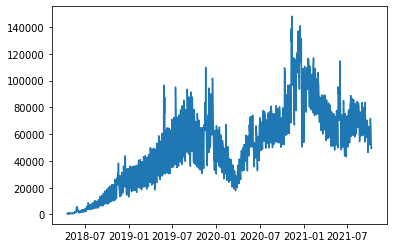

In [10]:
plt.plot(df['SI'])

### Estructura final de datos: Estandarizar,suavizar,dropnan, Features

In [11]:
df.columns

Index(['sit_site_id', 'WAREHOUSE', 'SI', 'SHP', 'ASP', 'flag_holiday_event',
       'flag_political_event', 'holiday', 'motivo', 'pais'],
      dtype='object')

In [12]:
list_features=['flag_holiday_event' ]
list_label=['SI']

data=df[list_label].copy()
#data=df[list_features+list_label].copy()
data.shape

(1271, 1)

### Train- Test Data

In [13]:
def train_test_split(df):
    df_train=df.iloc[: round(len(df)*0.8)]
    df_test=df.iloc[round(len(df)*0.8):]
    return df_train, df_test

In [14]:
data_train, data_test = train_test_split(data)

In [15]:
print('Verificar tamaños')
print('Shape data completa:', data.shape)
print('Shape data train:', data_train.shape) #2018-04-19/ 2021-02-15
print('Shape data test:', data_test.shape)   #2021-02-16/ 2021-10-31

Verificar tamaños
Shape data completa: (1271, 1)
Shape data train: (1017, 1)
Shape data test: (254, 1)


## LSTM UNIVARIANTE

### Min Max Scaler

In [16]:
def normalize(train, test):
    minmax = MinMaxScaler()
    train_scaled = minmax.fit_transform(train)
    test_scaled = minmax.transform(test)    
    return minmax, train_scaled, test_scaled

In [17]:
# reshape da forma a una matriz
scaler, data_train_scaled, data_test_scaled = normalize(data_train.values.reshape (-1, 1), data_test.values.reshape (-1, 1))

### Train - Test 3D structure

In [18]:
def processData_3D_structure (data_scaled, time_step_in): 
    X, y = [], [] 
    for i in range(time_step_in, data_scaled.shape[0]): 
        X.append (data_scaled[i-time_step_in:i, 0]) 
        y.append (data_scaled[i, 0]) 
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # entrada:debemos reajustar el tamaño del dataset para indicar que cada obs de entrada a la red será un vector de 35x1
    y = np.reshape(y, (y.shape[0], 1))             # salida: debemos especificar que su tamaño sera igual a 1, correspondiente a la predicción
    return X, y

In [19]:
time_step_in = 35 # predecir un valor en el futuro a partir de 35 valores pasados
X_train, y_train = processData_3D_structure(data_train_scaled, time_step_in) 
X_test, y_test= processData_3D_structure(data_test_scaled, time_step_in) 

print('Dimensions:')
print('\nDimension X_train',X_train.shape )
print('Dimension y_train',y_train.shape )
print('\nDimension X_test',X_test.shape )
print('Dimension y_test',y_test.shape )

Dimensions:

Dimension X_train (982, 35, 1)
Dimension y_train (982, 1)

Dimension X_test (219, 35, 1)
Dimension y_test (219, 1)


### RNN

In [27]:
#Hiperparametros rnn
batch_size_rnn= 32 # es el número de muestras entre las actualizaciones de peso del modelo
epochs_rnn= 300
n_neuronas=50 #50 # neuronas o bloques

In [28]:
def create_LSTM_RNN(input_shape):
    model = Sequential() #crea el contenedor de la red lstm
    #first LSTM
    model.add(LSTM(units=50,return_sequences=True,input_shape= X_train.shape[1:])) # se agrega la red especificandoles el numero de neuronas:50 y el tamaño de la entrada:35,1
    model.add(Dropout(0.2)) # regularizacion en las conexiones de entrada
    #second LSTM
    model.add(LSTM(units=n_neuronas,return_sequences=True))
    model.add(Dropout(0.2))
    #third LSTM
    model.add(LSTM(units=n_neuronas,return_sequences=True))
    model.add(Dropout(0.2))
    #fourth LSTM
    model.add(LSTM(units=n_neuronas))
    model.add(Dropout(0.2))

    #Output 
    model.add(Dense(units=1))    # para la capa de salida usamos la funcion dense y especificamos que el dato de salida tendra tamaño igual a 1
    model.compile(optimizer='adam',loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])
    return model

In [29]:
model_rnn = create_LSTM_RNN(X_train.shape[1:])  #crear modelo con el tamaño del X_train

In [30]:
history_rnn = model_rnn.fit(
    X_train,
    y_train,
    batch_size = batch_size_rnn, 
    verbose = 1,
    epochs = epochs_rnn, 
    validation_data = (X_test, y_test)
    #,callbacks=[early_stopping]
)

Epoch 1/300
31/31 [==============================] - 9s 112ms/step - loss: 0.0272 - mean_absolute_error: 0.1179 - val_loss: 0.0070 - val_mean_absolute_error: 0.0674
Epoch 2/300
31/31 [==============================] - 2s 68ms/step - loss: 0.0106 - mean_absolute_error: 0.0747 - val_loss: 0.0073 - val_mean_absolute_error: 0.0681
Epoch 3/300
31/31 [==============================] - 2s 69ms/step - loss: 0.0108 - mean_absolute_error: 0.0759 - val_loss: 0.0194 - val_mean_absolute_error: 0.1191
Epoch 4/300
31/31 [==============================] - 2s 68ms/step - loss: 0.0103 - mean_absolute_error: 0.0740 - val_loss: 0.0090 - val_mean_absolute_error: 0.0746
Epoch 5/300
31/31 [==============================] - 2s 69ms/step - loss: 0.0098 - mean_absolute_error: 0.0713 - val_loss: 0.0080 - val_mean_absolute_error: 0.0707
Epoch 6/300
31/31 [==============================] - 2s 68ms/step - loss: 0.0103 - mean_absolute_error: 0.0744 - val_loss: 0.0066 - val_mean_absolute_error: 0.0660
Epoch 7/300
31/

Text(0.5, 1.0, 'Test Dataset')

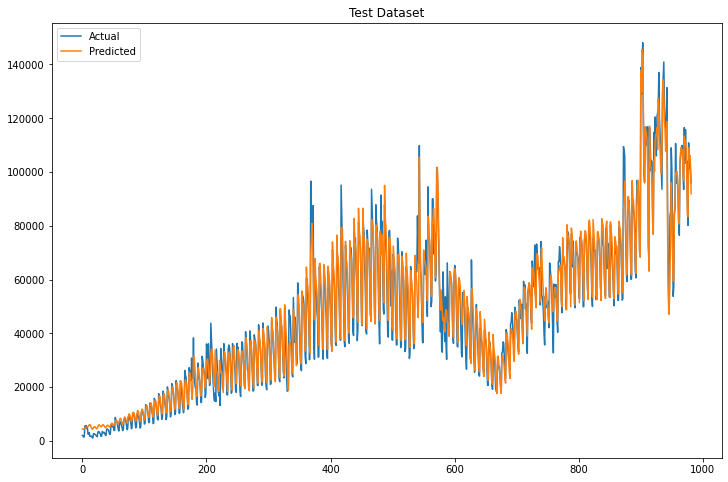

In [34]:
plt.figure(figsize=(12,8))
Xt = model_rnn.predict(X_train)
plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scaler.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")

In [35]:
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_train.reshape(-1,1)), scaler.inverse_transform(Xt))
accuracy = 1 - mape
accuracy #0.92

0.845201416579308

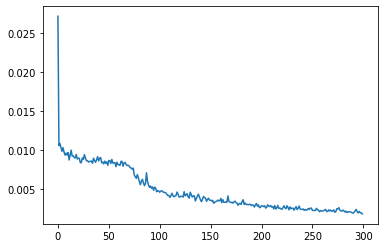

In [36]:
plt.plot(history_rnn.history['loss'])
plt.show()

In [68]:
'''se tiene que probar'''

def objective(trial):
    
    #clear_session()
    
    model = Sequential() #crea el contenedor de la red lstm
    #first LSTM
    model.add(LSTM(units=trial.suggest_categorical('units', [20, 100]),
                   return_sequences=True,
                   input_shape= X_train.shape[1:])) # se agrega la red especificandoles el numero de neuronas:50 y el tamaño de la entrada:35,1
    model.add(Dropout(0.2)) # regularizacion en las conexiones de entrada
    #second LSTM
    model.add(LSTM(units=trial.suggest_categorical('units', [20, 100]),return_sequences=True))
    model.add(Dropout(0.2))
    #third LSTM
    model.add(LSTM(units=trial.suggest_categorical('units', [20, 100]),return_sequences=True))
    model.add(Dropout(0.2))
    #fourth LSTM
    model.add(LSTM(units=trial.suggest_categorical('units', [20, 100])))
    model.add(Dropout(0.2))
    
    #Output 
    model.add(Dense(units=1))    # para la capa de salida usamos la funcion dense y especificamos que el dato de salida tendra tamaño igual a 1
    model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])#[tf.metrics.MeanAbsoluteError()])
    
    model.fit(X_train, y_train, 
              validation_data = (X_test, y_test), 
              shuffle=True,
              batch_size=32, 
              epochs=500,
              verbose=1)
    
    Xt = model.predict(X_test)
    mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(Xt))
    accuracy = 1 - mape
    return accuracy


El objetivo de un estudio es encontrar el conjunto óptimo de valores de hiperparámetros a través de múltiples ensayos (por ejemplo, n_trials=100). Optuna es un framework diseñado para la automatización y la aceleración de los estudios de optimización .

In [ ]:
study = optuna.create_study(direction="maximize") # Crea un nuevo estudio
study.optimize(objective, n_trials=100)#, timeout=600) #optimización de la función objetivo

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-01 13:11:04,521] A new study created in memory with name: no-name-e850a1dc-702a-4d3e-86b8-8275d7c086ca


Epoch 1/500
31/31 [==============================] - 10s 135ms/step - loss: 0.0244 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 3s 90ms/step - loss: 0.0101 - accuracy: 0.0010 - val_loss: 0.0128 - val_accuracy: 0.0000e+00
Epoch 3/500
31/31 [==============================] - 3s 91ms/step - loss: 0.0101 - accuracy: 0.0010 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 4/500
31/31 [==============================] - 3s 90ms/step - loss: 0.0093 - accuracy: 0.0010 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 5/500
31/31 [==============================] - 3s 90ms/step - loss: 0.0096 - accuracy: 0.0010 - val_loss: 0.0068 - val_accuracy: 0.0000e+00
Epoch 6/500
31/31 [==============================] - 3s 90ms/step - loss: 0.0097 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 7/500
31/31 [==============================] - 3s 89ms/step - loss: 0.0100 - accuracy: 0.0010 - val_loss: 0.

## LSTM MULTIVARIANTE

### Min Max Scaler

In [552]:
def normalize(train, test):
    minmax = MinMaxScaler()
    train_scaled = minmax.fit_transform(train)
    test_scaled = minmax.transform(test)    
    return minmax, train_scaled, test_scaled

In [554]:
#escalar los features X para train y test
scaler_X, data_train_scaled_X, data_test_scaled_X = normalize(data_train[list_features], data_test[list_features])

#scalar el label y para train y test
scaler_y, data_train_scaled_y, data_test_scaled_y = normalize(data_train[list_label], data_test[list_label])

#POR LA FORMA QUE ESTÁN HECHOS LOS CÓDIGOS NECESITO VOLVER A UNIR LAS FEATURES Y EL TARGET
data_train_scaled = np.hstack((data_train_scaled_X, data_train_scaled_y))
data_test_scaled =  np.hstack((data_test_scaled_X, data_test_scaled_y))

### Train - Test 3D structure

Primero, creamos datos en 35 pasos de tiempo antes de usar numpy para convertirlos en una matriz. Finalmente, convertimos los datos en una matriz 3D con muestras de X_train, 35 marcas de tiempo y una característica en cada paso.

In [555]:
def create_1_feature_data_time(data_scaled, time_step_in_in):
    '''
    Transformar datos de serie de tiempo al tipo acorde para red neuronal recurrente
    3D array with samples
    '''
    #funciona para una columna
    X = []
    y = []
    for i in range(time_step_in_in, data_scaled.shape[0]): # obs 35 hasta el largo del df
        X.append(data_scaled[i-time_step_in_in:i, 0]) #cada obs contempla 35 pasos
        y.append(data_scaled[i, 0]) # un valor
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # se deja para abajo
    y = np.reshape(y, (y.shape[0], 1))
    return X, y

In [556]:
def create_data_time(data_complete_scaled, time_window):
    for i in range(data_complete_scaled.shape[1]):  # recorre el número de columnas
        if i == 0:
            X, y = create_1_feature_data_time(data_complete_scaled[:, i].reshape(data_complete_scaled.shape[0], 1),  time_window  )
            X_features = X.copy()
            y_features = y.copy()
        else:
            X, y = create_1_feature_data_time(data_complete_scaled[:, i].reshape(data_complete_scaled.shape[0], 1),  time_window  )
            X_features = np.dstack((X_features,X))   #apilar en la tercera dimension (batch, ventana, features)
            y_features = np.hstack((y_features,y))   #apilar en la segunda dimension (batch, label)
    return X_features, y_features

In [557]:
X_train, y_train = create_data_time(data_complete_scaled = data_train_scaled, 
                                    time_window = 35)
X_test, y_test = create_data_time(data_complete_scaled = data_test_scaled, 
                                  time_window = 35)

In [558]:
print('Dimensions:')
print('\nDimension X_train',X_train.shape )
print('Dimension y_train',y_train.shape )
print('\nDimension X_test',X_test.shape )
print('Dimension y_test',y_test.shape )

Dimensions:

Dimension X_train (999, 35, 2)
Dimension y_train (999, 2)

Dimension X_test (223, 35, 2)
Dimension y_test (223, 2)


In [559]:
print('EXAMPLES')
print('First batch X_train, 35 observations, 3 tags\n',  X_train[0, :,:])
print('\nSecond batch X_train, 35 values, 3 tags - (34 antes de la observación, 1 NUEVA observación\n', X_train[1, :,:])
print('\nFirst batch y_test, 1 valor SIGUIENTE periodo, 3 tags UNO DE ELLOS EL DE INTERÉS\n', y_train[0, :] )

EXAMPLES
First batch X_train, 35 observations, 3 tags
 [[0.00000000e+00 1.44867690e-03]
 [0.00000000e+00 2.72811584e-03]
 [0.00000000e+00 1.21851328e-04]
 [0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.02109382e-03]
 [0.00000000e+00 2.43025704e-03]
 [0.00000000e+00 3.37798959e-03]
 [0.00000000e+00 1.65176244e-03]
 [0.00000000e+00 2.06470306e-03]
 [0.00000000e+00 1.28620846e-04]
 [0.00000000e+00 9.27423995e-04]
 [0.00000000e+00 5.15160336e-03]
 [1.00000000e+00 2.07147257e-03]
 [0.00000000e+00 3.62169224e-03]
 [0.00000000e+00 2.75519391e-03]
 [0.00000000e+00 1.42159882e-03]
 [0.00000000e+00 3.85862538e-04]
 [0.00000000e+00 8.80037368e-04]
 [0.00000000e+00 3.84508635e-03]
 [0.00000000e+00 3.37122007e-03]
 [0.00000000e+00 2.43702656e-03]
 [0.00000000e+00 2.26101908e-03]
 [0.00000000e+00 3.07336127e-03]
 [0.00000000e+00 5.00944348e-04]
 [0.00000000e+00 1.08312291e-03]
 [0.00000000e+00 5.77439904e-03]
 [0.00000000e+00 5.21252902e-03]
 [0.00000000e+00 4.41372588e-03]
 [0.00000000e+00 5.61

Respecto al orden de los tags, el ùltimo corresponde a la variable de interés. Para poder predicir solo la variable de interés se modifica el código

In [560]:
y_train = y_train[:, -1].reshape(y_train.shape[0], 1)
y_test = y_test[:, -1].reshape(y_test.shape[0], 1)

In [561]:
# data final
print('FINAL Dimensions')
print('\nDimension X_train',X_train.shape )
print('Dimension y_train',y_train.shape )
print('\nDimension X_test',X_test.shape )
print('Dimension y_test',y_test.shape )

FINAL Dimensions

Dimension X_train (999, 35, 2)
Dimension y_train (999, 1)

Dimension X_test (223, 35, 2)
Dimension y_test (223, 1)


### RNN

Keras Sequential: para inicializar la red neuronal 
LSTM : para agregar la capa LSTM
Dropout : para evitar el sobreajuste con capas de deserción
Dense: para agregar una capa de red neuronal densamente conectada.

La capa LSTM se agrega con los siguientes argumentos: 50 unidades es la dimensionalidad del espacio de salida, return_sequences = True es necesario para apilar capas LSTM, por lo que la capa LSTM consecuente tiene una entrada de secuencia tridimensional y input_shape es la forma del entrenamiento conjunto de datos.

Especificar 0.2 en la capa Dropout significa que se eliminarán el 20% de las capas

In [562]:
#definir "early stopping" la loss de validacion no mejora en X épocas

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=300,  #numero de epocas sin mejora
                                                  restore_best_weights = True)

In [563]:
#Hiperparametros rnn
batch_size_rnn= 32
epochs_rnn= 300

In [564]:
def create_LSTM_RNN(input_shape):
    #model by: https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233

    model = Sequential()
    #first LSTM
    model.add(LSTM(units=50,return_sequences=True,input_shape= input_shape   ))
    model.add(Dropout(0.2))
    #second LSTM
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))

    #third LSTM
    model.add(LSTM(units=50,return_sequences=True))
    model.add(Dropout(0.2))

    #fourth LSTM
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    #Output 
    model.add(Dense(units=1))    #4 quiero solo predecir pintas
    return model

Para compilar nuestro modelo usamos el optimizador de Adam y establecemos la pérdida como mean_squared_error. Después de eso, ajustamos el modelo para que se ejecute durante 200 épocas (las épocas son la cantidad de veces que el algoritmo de aprendizaje funcionará en todo el conjunto de entrenamiento) con un tamaño de lote de 32.

In [ ]:
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

In [565]:
model_rnn = create_LSTM_RNN(X_train.shape[1:])  #crear modelo con el tamaño del X_train
model_rnn.compile(optimizer='adam',loss='mse', metrics=[tf.metrics.MeanAbsoluteError()])  #compilar
model_rnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 35, 50)            10600     
                                                                 
 dropout_32 (Dropout)        (None, 35, 50)            0         
                                                                 
 lstm_36 (LSTM)              (None, 35, 50)            20200     
                                                                 
 dropout_33 (Dropout)        (None, 35, 50)            0         
                                                                 
 lstm_37 (LSTM)              (None, 35, 50)            20200     
                                                                 
 dropout_34 (Dropout)        (None, 35, 50)            0         
                                                                 
 lstm_38 (LSTM)              (None, 50)              

In [566]:
history_rnn = model_rnn.fit(
    X_train,
    y_train,
    batch_size = batch_size_rnn,
    verbose = 1,
    epochs = epochs_rnn,
    validation_data = (X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/300
32/32 [==============================] - 8s 104ms/step - loss: 0.0294 - mean_absolute_error: 0.1244 - val_loss: 0.0070 - val_mean_absolute_error: 0.0680
Epoch 2/300
32/32 [==============================] - 2s 65ms/step - loss: 0.0108 - mean_absolute_error: 0.0763 - val_loss: 0.0100 - val_mean_absolute_error: 0.0791
Epoch 3/300
32/32 [==============================] - 2s 62ms/step - loss: 0.0105 - mean_absolute_error: 0.0748 - val_loss: 0.0069 - val_mean_absolute_error: 0.0664
Epoch 4/300
32/32 [==============================] - 2s 63ms/step - loss: 0.0102 - mean_absolute_error: 0.0732 - val_loss: 0.0067 - val_mean_absolute_error: 0.0671
Epoch 5/300
32/32 [==============================] - 2s 63ms/step - loss: 0.0114 - mean_absolute_error: 0.0768 - val_loss: 0.0071 - val_mean_absolute_error: 0.0691
Epoch 6/300
32/32 [==============================] - 2s 63ms/step - loss: 0.0109 - mean_absolute_error: 0.0756 - val_loss: 0.0067 - val_mean_absolute_error: 0.0661
Epoch 7/300
32/

### Visualizar Pérdida

In [145]:
#visualizar loss
def visualize_loss_model(loss_train, loss_valid, tittle, both = False, loss_train_2 = None, loss_valid_2 = None):
    if both==False:
        plt.plot(loss_train, color='gray', label = 'loss_train', linestyle = '-')
        plt.plot(loss_valid, color = 'purple', label = 'loss_test')
    if both ==True:
        fig = plt.figure(figsize=((8,8)))
        plt.plot(loss_train, color='gray', label = 'loss_train_mlp', linestyle = '-')
        plt.plot(loss_valid, color = 'purple', label = 'loss_test_mlp')
        plt.plot(loss_train_2, color= 'blue', label = 'loss_train_rnn', linestyle = '-')
        plt.plot(loss_valid_2, color = 'pink', label = 'loss_test_rnn') 

    plt.title(tittle, fontsize = 18)
    plt.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
    plt.xlabel('Epochs', fontsize = 13)
    plt.legend()

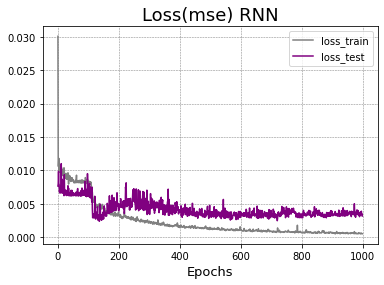

In [146]:
rnn_loss=history_rnn.history['loss']
rnn_val_loss=history_rnn.history['val_loss']
visualize_loss_model(rnn_loss, rnn_val_loss, 'Loss(mse) RNN', False)

### Visualizar Predicciones

In [147]:
#visualizar predicciones
def visualize_predictions_individual(data_real, data_pred, name, both= False, data_pred_2 = None):  #creo que la data_pred_2 es para data de test (train, valid, test)
    fig = plt.figure(figsize = ((10,7)))
    x_space = np.linspace(1, len(data_real), len(data_real))
    if both == False:
        plt.plot(data_real, linestyle = '-', label = 'real')
        plt.plot(x_space, data_pred, linestyle = '-', color = 'red', alpha = 0.5, label = 'prediction')
        #plt.scatter(x_space, data_pred, marker = 'x', color = 'red', alpha = 0.5, label = 'prediction')
    if both == True:
        plt.plot(data_real, linestyle = '-', label = 'real')
        plt.scatter(x_space, data_pred, marker = 'x', color = 'red', alpha = 0.5, label = 'prediction_mlp')
        plt.scatter(x_space, data_pred_2, marker = 'o', color = 'green', alpha = 0.5, label = 'prediction_rnn')

    plt.legend()
    plt.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
    plt.xlabel('Time', fontsize = 13)
    plt.ylabel(name, fontsize = 13)
    plt.xticks([])
    plt.title('Test: Real vs Predict (' +name +')', fontsize = 15)

In [148]:
predict_train_rnn= model_rnn.predict(X_train)
y_train_predicted_rnn= scaler_y.inverse_transform(predict_train_rnn)
y_train_real=scaler_y.inverse_transform(y_train)

NameError: name 'scaler_y' is not defined

In [149]:
predict_train_rnn= model_rnn.predict(X_train)
y_train_predicted_rnn= scaler_y.inverse_transform(predict_train_rnn)
y_train_real=scaler_y.inverse_transform(y_train)

predict_test_rnn= model_rnn.predict(X_test)
y_test_predicted_rnn= scaler_y.inverse_transform(predict_test_rnn)
y_test_real=scaler_y.inverse_transform(y_test)

prueba_y_predicted=np.concatenate((y_train_predicted_rnn, y_test_predicted_rnn), axis=0, out=None)
prueba_y_real=np.concatenate((y_train_real, y_test_real), axis=0, out=None)

NameError: name 'scaler_y' is not defined

In [572]:
prueba_y_predicted=np.concatenate((y_train_predicted_rnn, y_test_predicted_rnn), axis=0, out=None)
prueba_y_real=np.concatenate((y_train_real, y_test_real), axis=0, out=None)

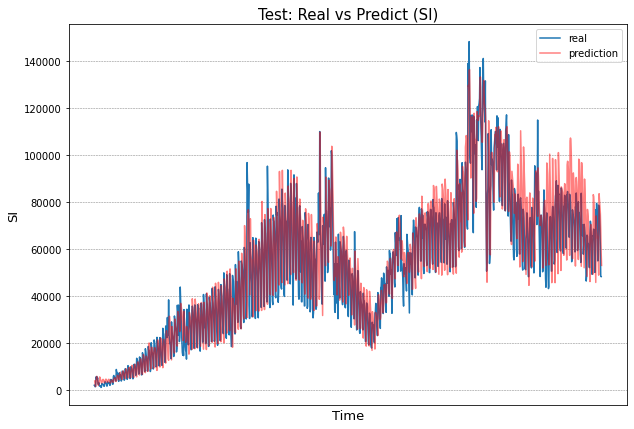

In [573]:
visualize_predictions_individual(data_real= prueba_y_real,
                                 data_pred=prueba_y_predicted,
                                 name=list_label[0],
                                 both= False,
                                 data_pred_2= None) #para graficar también data test (train,test,val)

In [508]:
predict_test_rnn= model_rnn.predict(X_train)
y_test_predicted_rnn= scaler_y.inverse_transform(predict_test_rnn)
y_test_real=scaler_y.inverse_transform(y_train)

In [574]:
import scipy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
rmse = mean_squared_error(prueba_y_real, prueba_y_predicted,squared=False)
mape = mean_absolute_percentage_error(prueba_y_real, prueba_y_predicted)
accuracy = 1 - mape

In [575]:
accuracy

0.8739127601548897

In [60]:
import scipy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, median_absolute_error